In [1]:
#import user modules
#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import sys
my_path = "../../Python/"
if my_path not in sys.path:
    sys.path.append(my_path)
 
for place in sys.path: 
    print(place)

import costfun.costfun as cost
import utils.figures as fig_help

import importlib as imp
def reload_modules():
    imp.reload(cost)
    imp.reload(fig_help)

import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
latex_engine = 'xelatex'
latex_elements = {'preamble':r'\usepackage{physics}'}

%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:120])
colors_ls_cyc = itertools.cycle(colors_ls)
markers_ls = ['o','s','v', 'D', '<', 'X', '^', '*', '+']
markers = itertools.cycle(markers_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.special import lambertw
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
from scipy import integrate
from scipy import fft
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from os import sep as kPSep
from os.path import exists

base_dir = "../results/"


/Users/rafal.swietek/Projects/QHamSolver/QuantumSun/Jupyter_Python
/Users/rafal.swietek/opt/anaconda3/lib/python39.zip
/Users/rafal.swietek/opt/anaconda3/lib/python3.9
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/lib-dynload

/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/aeosa
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions
/Users/rafal.swietek/.ipython
../../Python/


In [2]:
def order_of_magnitude2(a_value):
    #return 2
    if np.abs(a_value) < 1.0 and a_value != 0:
        m = np.abs(np.log10(np.abs(a_value)))
        return int(max(math.ceil(m) + 1., 2.))
    else: 
        return 2

def order_of_magnitude(a_value):
    num_str = f"{a_value - int(a_value)}"
    num_str = num_str[2:]
    _size = len(num_str)
    if num_str == "0":
        _size = 0;
    
    return _size
    
def info_raw(L, M, J, gamma, zeta, alfa, h, w, ini_ave = 0, use_old = False):
    arr = [J, gamma, zeta, alfa, h, w]
    names = ['J', 'g', 'zeta', 'alfa', 'h', 'w']
    info = "_L=%d,M=%d"%(L,M)
    for i, var in enumerate(arr):
        n = order_of_magnitude2(var) if use_old else order_of_magnitude(var)
        info += str(",%s={:.%df}"%(names[i], n)).format(round(var, n))
    info += ",ini_ave=%d"%ini_ave
    return info

def info(L, M, J, gamma, zeta, alfa, h, w, ini_ave = 0, use_old = False):
    return info_raw(L, M, J, gamma, zeta, alfa, h, w, ini_ave, use_old) + ".dat"


def GOE(x : np.array):
    """
    GOE shape of sff in thermodynamic limit
    
    Parameters:
    -----------------
        x : np.array
            numpy array with datapoints (times defined for unfolded data)
    """
    return np.array([2 * a - a * np.log(1 + 2 * a) if a < 1 else 2 - a * np.log( (2 * a + 1) / (2 * a - 1) ) for a in x])

def remove_fluctuations(data, bucket_size=10):
    new_data = data;
    half_bucket = int(bucket_size / 2)
    for k in range(half_bucket, len(data) - half_bucket):
        average = np.sum(data[k - half_bucket : k + half_bucket])
        new_data[k - half_bucket] = average / bucket_size
    return new_data

dir_E = base_dir + 'DIAGONALIZATION/'

[ 2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5
  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5
 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20. ]


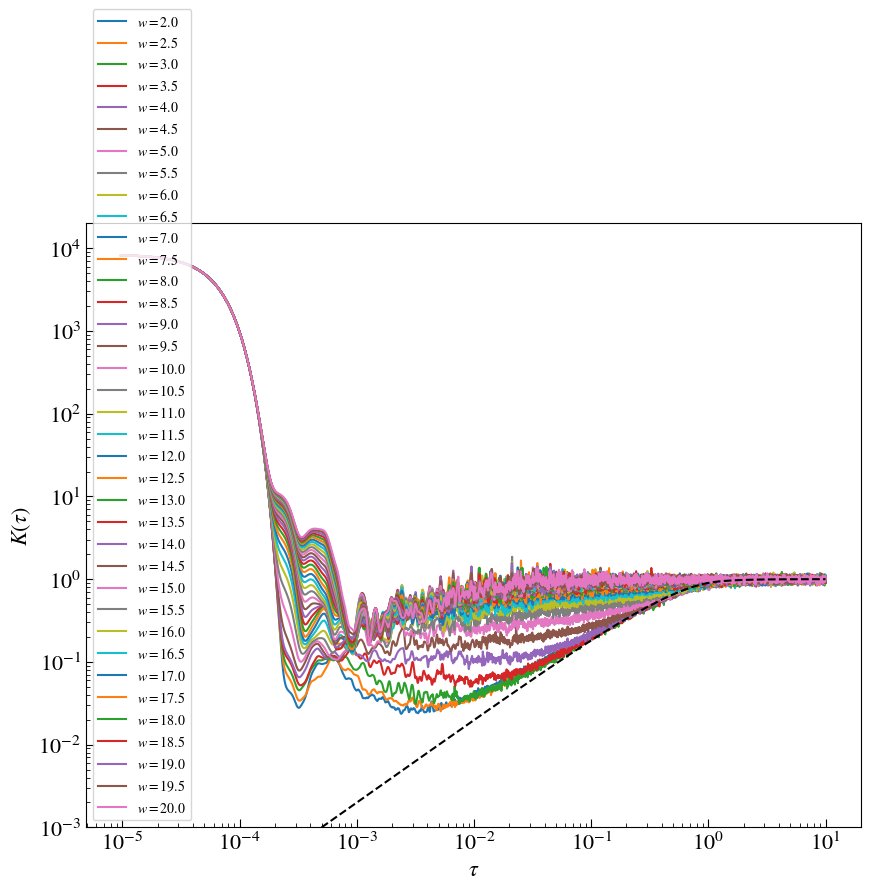

In [3]:
L=14
J=1.0
alfa=1.00
h=0.0
w=2.0
zeta=0.2
M=3
gamma=1.0
ini_ave=1

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(10,8), dpi = 100)

FOLDED = False

alfa_vals = np.linspace(0.7, 0.85, 16)
w_vals = np.linspace(2.0, 14.5, 26)
w_vals = np.linspace(2.0, 20.0, 37)
print(w_vals)
sizes = np.arange(10, 16, 1)
times = [1]
#for L in sizes:
#for alfa in alfa_vals:
for w in w_vals:
    filename = base_dir + "SpectralFormFactor/" + ("folded" if FOLDED else "") + info(L, M, J, gamma, zeta, alfa, h, w, ini_ave)
    #if not exists(filename):
    #    filename = base_dir + "SpectralFormFactor/" + ("folded" if FOLDED else "") + info(L, M, J, gamma, zeta, alfa, h, w, ini_ave, use_old=True)
    if exists(filename):
        data = pd.read_table(filename, sep="\t", header=None)
        times = np.array(data[0])
        sff = np.array(data[1])
        #sff = remove_fluctuations(sff, int(0.005 * len(sff)))
        tH = data[2][0]
        gap_ratio = data[4][0]
        axis.plot(times, sff, lw=1.5, label=r"$w=%.1f$"%w)
    else:
        print(filename)

axis.plot(times, GOE(times), ls='--', color='black')
#axis.axhline(y=0.38, ls=':', lw=2, color='black')
axis.legend()
axis.set_ylim(1e-3, 2e4)
axis.set_xscale('log')
axis.set_yscale('log')
axis.set_ylabel(r"$K(\tau)$", fontsize=16)
axis.set_xlabel(r"$\tau$", fontsize=16)
axis.tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
axis.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
#axis.set_ylim(0, 1.1)

In [10]:
epsilon=8e-2

def get_points(L, gamma):
    w_L = []
    tau_L = []
    tH_L = []
    gaps_L = []
    #for alfa in alfa_vals:
    w_vals = np.linspace(2.0, 20.0, 37)
    for w in w_vals:
    
        filename = base_dir + "SpectralFormFactor/" + ("folded" if FOLDED else "") + info(L, M, J, gamma, zeta, alfa, h, w, ini_ave)
        if exists(filename):
            w_L.append(w)
            data = pd.read_table(filename, sep="\t", header=None)
            times = np.array(data[0])
            sff = np.array(data[1])
            sff = remove_fluctuations(sff, int(0.01 * len(sff)))
            tH = data[2][0]
            gap_ratio = data[4][0]
            times_for_algorithm = times / tH if FOLDED else times
            sff_dev = np.abs(np.log10(sff / GOE(times_for_algorithm)))
            tau = np.nan
            for i, K in reversed(list(enumerate(sff_dev))):
                if K > epsilon and times[i] < (3 * tH if FOLDED else 3):
                    tau = times[i-1]
                    break
            tau_L.append(tau)
            tH_L.append(tH)
            gaps_L.append(gap_ratio)
            
        else:
            print(filename)
    
    return np.array(w_L), np.array(gaps_L), np.array(tau_L), np.array(tH_L)

[ 2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5
  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5
 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20. ]
../results/SpectralFormFactor/_L=10,M=3,J=1,g=4,zeta=0.2,alfa=1,h=0,w=2,ini_ave=1.dat
../results/SpectralFormFactor/_L=10,M=3,J=1,g=4,zeta=0.2,alfa=1,h=0,w=2.5,ini_ave=1.dat
../results/SpectralFormFactor/_L=11,M=3,J=1,g=4,zeta=0.2,alfa=1,h=0,w=2,ini_ave=1.dat
../results/SpectralFormFactor/_L=11,M=3,J=1,g=4,zeta=0.2,alfa=1,h=0,w=2.5,ini_ave=1.dat
../results/SpectralFormFactor/_L=12,M=3,J=1,g=4,zeta=0.2,alfa=1,h=0,w=2,ini_ave=1.dat
../results/SpectralFormFactor/_L=12,M=3,J=1,g=4,zeta=0.2,alfa=1,h=0,w=2.5,ini_ave=1.dat
../results/SpectralFormFactor/_L=13,M=3,J=1,g=4,zeta=0.2,alfa=1,h=0,w=2,ini_ave=1.dat
../results/SpectralFormFactor/_L=13,M=3,J=1,g=4,zeta=0.2,alfa=1,h=0,w=2.5,ini_ave=1.dat
../results/SpectralFormFactor/_L=14,M=3,J=1,g=4,zeta=0.2,alfa=1,h=0,w=2,ini_ave=1.dat
../results/SpectralFormFactor

No handles with labels found to put in legend.


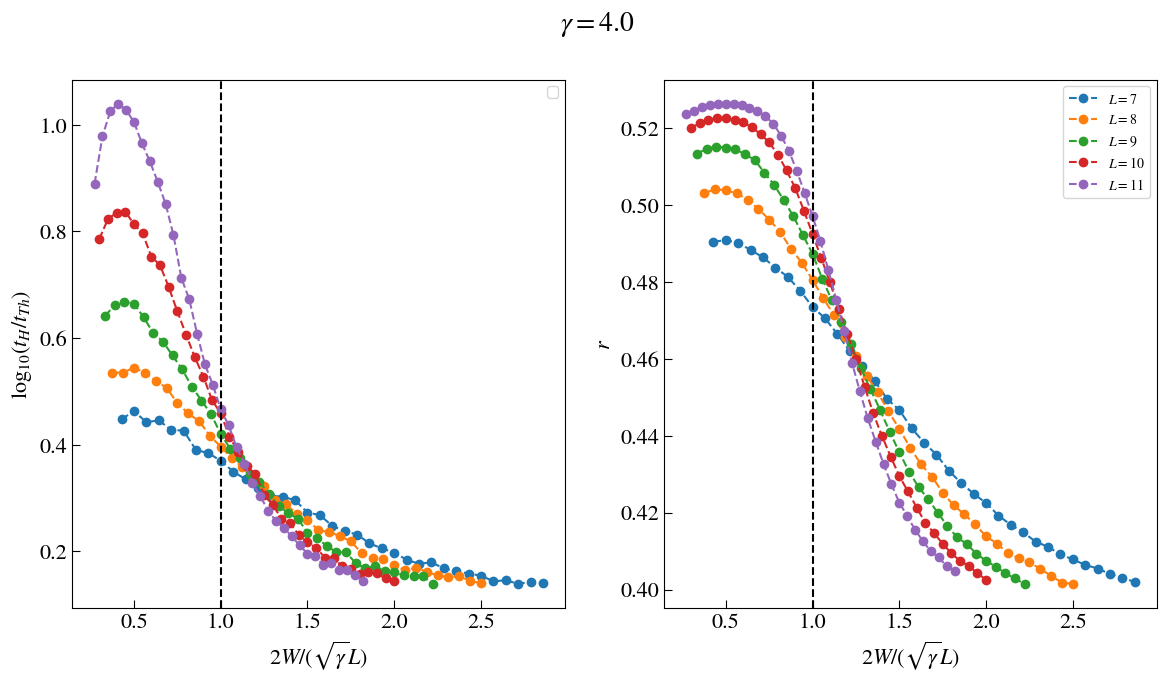

In [11]:
reload_modules()

FOLDED = False
L=14
J=1.0
alfa=1.00
h=0.0
w=2.0
zeta=0.2
M=3
gamma=3.0
ini_ave=1

COLLAPSE = 0
gamma_vals = np.linspace(1.0, 4.0, 13)
gamma_vals = [4.0]
for gamma in gamma_vals:
    fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(14,7), dpi = 100)

    taus = []
    gaps = []
    heisenberg_time = []
    times = [1]
    #w_vals = np.linspace(0.2, 4.0, 20)
    print(w_vals)
    sizes = np.array([10, 11, 12, 13, 14])
    w_plot = []
    for L in sizes:
        w_L, gaps_L, tau_L, tH_L = get_points(L, gamma)

        w_plot.append(np.array(w_L))

        taus.append(np.array(tau_L))
        heisenberg_time.append(np.array(tH_L))
        gaps.append(gaps_L)
        

    gaps = np.array(gaps)
    taus = np.array(taus)
    w_plot = np.array(w_plot)

    if COLLAPSE:
        idx = 0
        xdata = [wx[idx:] for wx in w_plot]
        ydata = [r[idx:] for r in gaps]
        par1, crit_pars1, costfun, status = cost.get_crit_points(x=np.array(xdata), y=np.array(ydata), vals=sizes, crit_fun='lin', scaling_ansatz='KT', seed=412438923)
        print(par1, crit_pars1)

        #ydata = [tTh[idx:] for tTh in np.log10(1.0 / taus)]
        par2, crit_pars2, costfun, status = cost.get_crit_points(x=np.array(xdata), y=np.array(ydata), vals=sizes, crit_fun='lin', scaling_ansatz='KT', seed=412438923)
        print(par2, crit_pars2)

        rescale_fun = cost.resc_functions_dict['KT']
        critical_fun = cost.crit_functions_dict['lin']
        xlab = cost.scale_ansatz_label['KT']('W')
        for ii, L in enumerate(sizes):
            g_cond = np.log10(1.0 / taus[ii])
            axis[0].plot(rescale_fun(w_plot[ii], L, critical_fun, par1, *crit_pars1), g_cond, ls='--', marker='o')
            axis[1].plot(rescale_fun(w_plot[ii], L, critical_fun, par2, *crit_pars2), gaps[ii], ls='--', marker='o', label=r"$L=%d$"%(L-M))
    else:
        for ii, L in enumerate(sizes):
            g_cond = np.log10(1.0 / taus[ii])
            axis[0].plot(w_plot[ii] * 2 / (np.sqrt(gamma) * (L-M)), g_cond, ls='--', marker='o')
            axis[1].plot(w_plot[ii] * 2 / (np.sqrt(gamma) * (L-M)), gaps[ii], ls='--', marker='o', label=r"$L=%d$"%(L-M))

    #axis.plot(times, GOE(times), ls='--', color='black')
    axis[0].set_ylabel(r"$\log_{10}(t_H/t_{Th})$", fontsize=16)
    axis[1].set_ylabel(r"$r$", fontsize=16)
    for ax in axis:
        if COLLAPSE: ax.set_xlabel(f"${xlab}$", fontsize=16)
        else: ax.set_xlabel(r"$2W/(\sqrt{\gamma}L)$", fontsize=16)
        
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        ax.tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
        ax.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
        ax.legend()
        ax.axvline(x=1.0, ls='--', color='black')
        #ax.set_xlim(0.5, 1.5)
    fig.suptitle(f"$\gamma={gamma}$", fontsize=20)
    #axis.set_ylim(0, 1.1)
    #axis[1].set_xlim(0,7)
    with open(f'results/disorder_gamma={gamma},M={M},alfa={alfa},zeta={zeta},ini_ave={ini_ave}_L=10_14.npy', 'wb') as file: np.save(file, np.array(w_plot), allow_pickle=True)
    with open(f'results/gap_ratio_gamma={gamma},M={M},alfa={alfa},zeta={zeta},ini_ave={ini_ave}_L=10_14.npy', 'wb') as file: np.save(file, np.array(gaps), allow_pickle=True)
    with open(f'results/thouless_gamma={gamma},M={M},alfa={alfa},zeta={zeta},ini_ave={ini_ave}_L=10_14.npy', 'wb') as file: np.save(file, np.array(taus), allow_pickle=True)
    plt.savefig(f"plots/GapRatio_rescaled_gamma={gamma}_alfa={alfa}_ini_ave={ini_ave}.pdf", bbox_inches = 'tight', pad_inches=0.02)
    plt.savefig(f"plots/GapRatio_rescaled_gamma={gamma}_alfa={alfa}_ini_ave={ini_ave}.png", bbox_inches = 'tight', pad_inches=0.02)

[ 2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5
  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5
 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20. ]
../results/SpectralFormFactor/_L=14,M=3,J=1,g=1.25,zeta=0.2,alfa=1,h=0,w=2,ini_ave=1.dat
../results/SpectralFormFactor/_L=14,M=3,J=1,g=1.25,zeta=0.2,alfa=1,h=0,w=2.5,ini_ave=1.dat
../results/SpectralFormFactor/_L=14,M=3,J=1,g=1.5,zeta=0.2,alfa=1,h=0,w=2,ini_ave=1.dat
../results/SpectralFormFactor/_L=14,M=3,J=1,g=1.5,zeta=0.2,alfa=1,h=0,w=2.5,ini_ave=1.dat
../results/SpectralFormFactor/_L=14,M=3,J=1,g=1.75,zeta=0.2,alfa=1,h=0,w=2,ini_ave=1.dat
../results/SpectralFormFactor/_L=14,M=3,J=1,g=1.75,zeta=0.2,alfa=1,h=0,w=2.5,ini_ave=1.dat
../results/SpectralFormFactor/_L=14,M=3,J=1,g=2.25,zeta=0.2,alfa=1,h=0,w=2,ini_ave=1.dat
../results/SpectralFormFactor/_L=14,M=3,J=1,g=2.25,zeta=0.2,alfa=1,h=0,w=2.5,ini_ave=1.dat
../results/SpectralFormFactor/_L=14,M=3,J=1,g=2.5,zeta=0.2,alfa=1,h=0,w=2,ini_ave=1.dat
../re

No handles with labels found to put in legend.


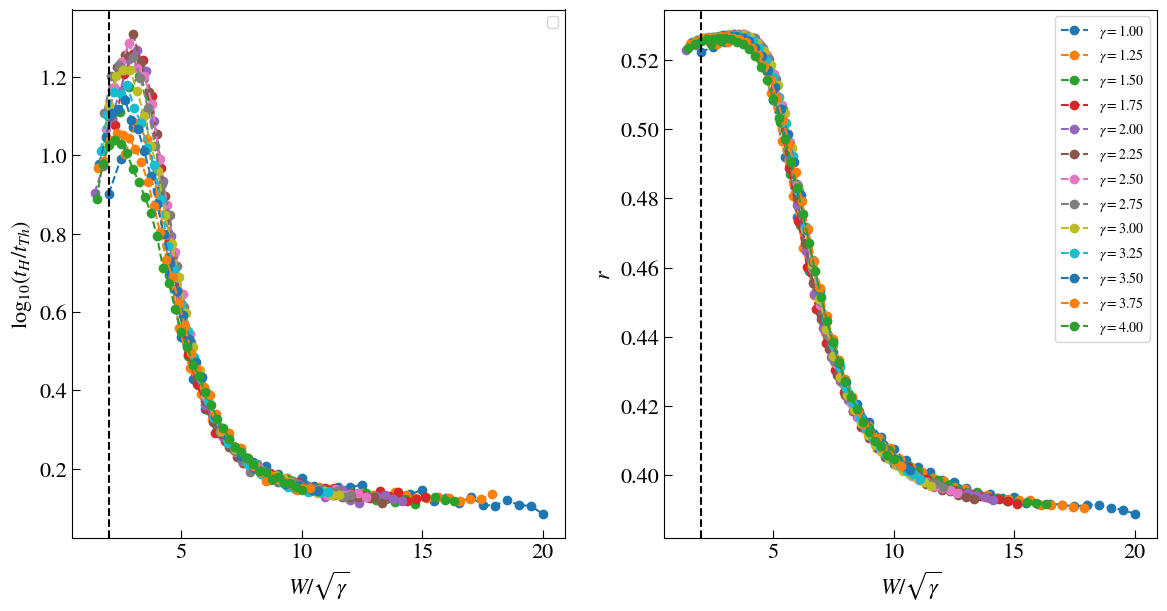

In [12]:
reload_modules()

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(14,7), dpi = 100)

FOLDED = False
L=14
J=1.0
alfa=1.00
h=0.0
w=2.0
zeta=0.2
M=3
gamma=3.0
ini_ave=1

COLLAPSE = 0

taus = []
gaps = []
heisenberg_time = []
times = [1]
#w_vals = np.linspace(0.2, 4.0, 20)
print(w_vals)
epsilon=8e-2
sizes = np.array([10, 11, 12, 13, 14, 15])
gamma_vals = np.linspace(1.0, 4.0, 13)
#gamma_vals = [1.0, 2.0, 3.0, 4.0]

w_plot = []
#for L in sizes:
for gamma in gamma_vals:
    
    w_L, gaps_L, tau_L, tH_L = get_points(L, gamma)
    
    w_plot.append(np.array(w_L))

    taus.append(np.array(tau_L))
    heisenberg_time.append(np.array(tH_L))
    gaps.append(np.array(gaps_L))
    

gaps = np.array(gaps)
taus = np.array(taus)
w_plot = np.array(w_plot)

if COLLAPSE:
    idx = 0
    xdata = [wx[idx:] for wx in w_plot]
    ydata = [r[idx:] for r in gaps]
    par1, crit_pars1, costfun, status = cost.get_crit_points(x=np.array(xdata), y=np.array(ydata), vals=gamma_vals, crit_fun='lin', scaling_ansatz='KT', seed=412438923)
    print(par1, crit_pars1)

    #ydata = [tTh[idx:] for tTh in np.log10(1.0 / taus)]
    par2, crit_pars2, costfun, status = cost.get_crit_points(x=np.array(xdata), y=np.array(ydata), vals=gamma_vals, crit_fun='lin', scaling_ansatz='KT', seed=412438923)
    print(par2, crit_pars2)

    rescale_fun = cost.resc_functions_dict['KT']
    critical_fun = cost.crit_functions_dict['lin']
    xlab = cost.scale_ansatz_label['KT']('W')
    for ii, L in enumerate(gamma_vals):
        g_cond = np.log10(1.0 / taus[ii])
        axis[0].plot(rescale_fun(w_plot[ii], L, critical_fun, par1, *crit_pars1), g_cond, ls='--', marker='o')
        axis[1].plot(rescale_fun(w_plot[ii], L, critical_fun, par2, *crit_pars2), gaps[ii], ls='--', marker='o', label=r"$L=%d$"%(L-M))
else:
    for ii, gamma in enumerate(gamma_vals):
        g_cond = np.log10(1.0 / taus[ii])
        axis[0].plot(w_plot[ii] / np.sqrt(gamma), g_cond, ls='--', marker='o')
        axis[1].plot(w_plot[ii] / np.sqrt(gamma), gaps[ii], ls='--', marker='o', label=r"$\gamma=%.2f$"%(gamma))

#axis.plot(times, GOE(times), ls='--', color='black')
axis[0].set_ylabel(r"$\log_{10}(t_H/t_{Th})$", fontsize=16)
axis[1].set_ylabel(r"$r$", fontsize=16)
for ax in axis:
    if COLLAPSE: ax.set_xlabel(f"${xlab}$", fontsize=16)
    else: ax.set_xlabel(r"$W/\sqrt{\gamma}$", fontsize=16)
    
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    ax.tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
    ax.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
    ax.legend()
    ax.axvline(x=2.0, ls='--', color='black')
    #ax.set_xlim(0.5, 1.5)
#axis.set_ylim(0, 1.1)
#axis[1].set_xlim(0,7)

with open(f'results/disorder_L={L},M={M},alfa={alfa},zeta={zeta},ini_ave={ini_ave}_gamma=1.0,4.0,0.25.npy', 'wb') as file: np.save(file, np.array(w_plot), allow_pickle=True)
with open(f'results/gap_ratio_L={L},M={M},alfa={alfa},zeta={zeta},ini_ave={ini_ave}_gamma=1.0,4.0,0.25.npy', 'wb') as file: np.save(file, np.array(gaps), allow_pickle=True)
with open(f'results/thouless_L={L},M={M},alfa={alfa},zeta={zeta},ini_ave={ini_ave}_gamma=1.0,4.0,0.25.npy', 'wb') as file: np.save(file, np.array(taus), allow_pickle=True)
#plt.savefig(f"GapRatio_rescaled_gamma={gamma}_alfa={alfa}_ini_ave={ini_ave}.pdf", bbox_inches = 'tight', pad_inches=0.02)
#plt.savefig(f"GapRatio_rescaled_gamma={gamma}_alfa={alfa}_ini_ave={ini_ave}.png", bbox_inches = 'tight', pad_inches=0.02)

In [13]:

def typical(data):
    return np.exp(np.sum(np.log(data) / len(data)))

basedir = "./cost_fun_results/"
sizes = range(10, 15, 1)
def load_critical_data(crit_fun = 'free', scaling_ansatz = 'RG', name = "GapRatio", gamma = 3.0, size_collapse = True, L = 14):
    cost_fun = []
    crit_exp = []
    crit_pars = []
    for file in os.listdir(basedir):
        info = (f"_gamma={gamma}" if size_collapse else f"_L={L}") + f",M={M},alfa={alfa},zeta={zeta},ini_ave={ini_ave}"
        prefix = name + info + "_critfun=%s_ansatz=%s_seed"%(crit_fun, scaling_ansatz)
        #print(prefix)
        if file.startswith(prefix):
            file = basedir + file
            if os.path.exists(file):
                data = np.load(file)
                cost_fun.append(data['costfun'])
                crit_exponents = data["crit exp"]
                crit_exp.append(crit_exponents)
                critics = []
                for i in range(len(data) - 2):
                    critics.append(data["x_%d"%i])
                crit_pars.append(np.array(critics))

    if len(crit_pars) > 0:
        num_of_sizes = len(crit_pars[0])
        crit_pars = np.transpose(crit_pars)
        return np.array(cost_fun), np.array(crit_exp), np.array(crit_pars), num_of_sizes
    else:
        return [], [], [], 0
        #raise RuntimeError("No cost function results found!")
cost_fun, crit_exp, crit_pars, num_of_crit = load_critical_data(size_collapse=False, L=14)



print(np.median(crit_exp))
print([np.median(crit_pars[i]) for i in range(num_of_crit)])


9.963550448696868
[8.274131476938955, 8.906305840352493, 9.611523367860869, 10.325523883240209, 10.88672819993117, 11.57784938363088, 12.276134547741776, 12.746441983595272, 13.229093985125257, 13.819864376862348, 14.381866813291975, 14.689961398102252, 15.086291504338934]


0.10052586257384011
[6.719430370228645, 7.284002558832755, 8.263682748147557, 8.71945236989693, 9.430501615022992, 10.154531332564003, 10.729218698232787, 11.224621912674145, 11.715321947990475, 12.480867954786344, 12.969750621623508, 13.324894351607606, 13.689301586622936]
9.961004636877007
[6.864720524745589, 7.257337479268923, 8.156092819581394, 8.806748743944311, 9.271547454437531, 9.941940869254939, 10.832948852431647, 11.361909807789768, 11.859130283721369, 12.37914786809864, 12.842607618229946, 13.313293830150496, 13.607825729363299]
9.963550448696868
[8.274131476938955, 8.906305840352493, 9.611523367860869, 10.325523883240209, 10.88672819993117, 11.57784938363088, 12.276134547741776, 12.746441983595272, 13.229093985125257, 13.819864376862348, 14.381866813291975, 14.689961398102252, 15.086291504338934]


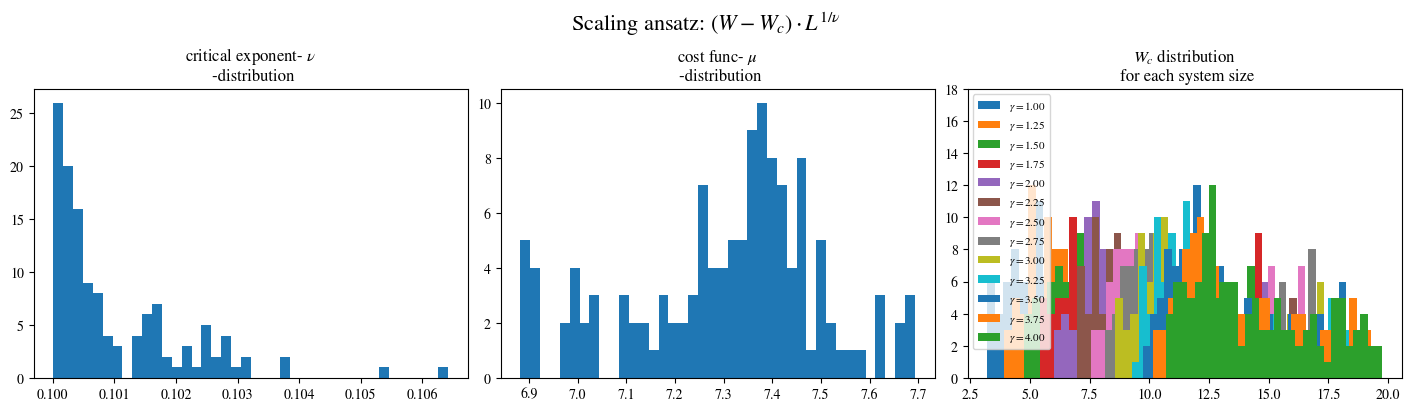

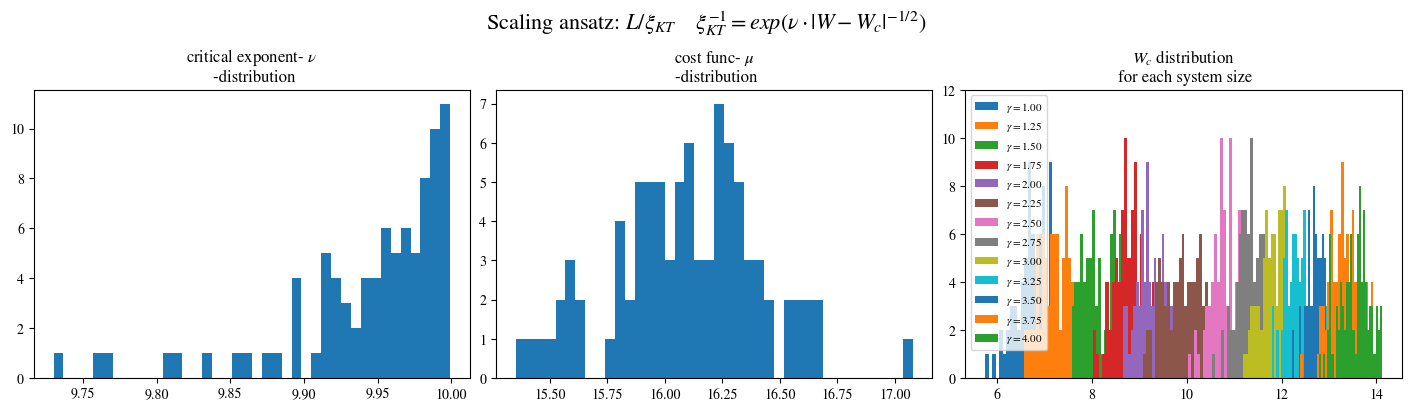

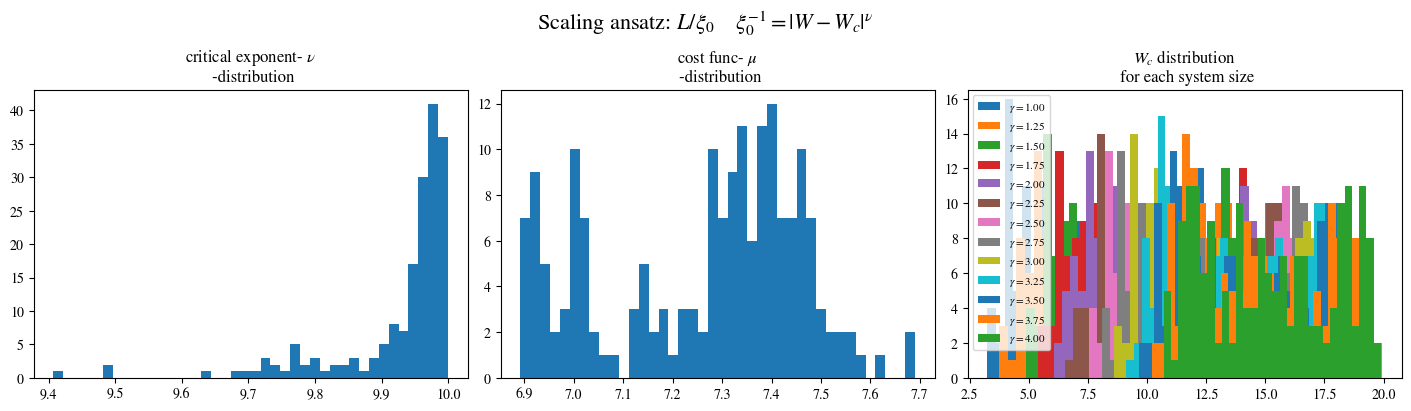

In [15]:
gamma = 3.0
L=14

def plot_dist(crit_fun = 'free', scaling_ansatz = 'FGR', name="GapRatio", size_collapse = True):
   
    fig, (ax1, ax2, ax3) = plt.subplots( nrows=1, ncols=3, figsize=(14,4), dpi = 100, constrained_layout=True, sharey=False)    

    cost_fun, crit_exp, crit_pars, num_of_crit = load_critical_data(crit_fun=crit_fun, scaling_ansatz=scaling_ansatz, name=name, size_collapse=size_collapse)

    ylab = 'W'
    ax1.hist(crit_exp, bins = 40)
    ax1.set_title("critical exponent- " + r"$\nu$" + "\n -distribution")

    ax2.hist(cost_fun, bins = 40)
    ax2.set_title("cost func- " + r"$\mu$" + "\n -distribution")
    
    for i in range(num_of_crit):
        lab = r"$L=%d$"%(sizes[i]) if size_collapse else r"$\gamma=%.2f$"%(gamma_vals[i])
        ax3.hist(crit_pars[i], bins = 30, label=lab, histtype='bar', linewidth=3, stacked=True)

    hist, edge = np.histogram((crit_pars[-1]), bins = 30)
    ax3.set_ylim( None, 1.5*max( hist ) )
    ax3.set_title(r"$%s_c$"%ylab + " distribution\n for each system size")


    
    ax3.legend(fontsize=8)
    print(np.median(crit_exp))
    print([np.median(crit_pars[i]) for i in range(num_of_crit)])
    lab = 'W'
    fig.suptitle("Scaling ansatz:\t" + r"$%s$"%cost.scale_ansatz_label[scaling_ansatz](lab), fontsize=16)

plot_dist(scaling_ansatz='classic', crit_fun='free', size_collapse=False)
plot_dist(scaling_ansatz='KT', crit_fun='free', size_collapse=False)
plot_dist(scaling_ansatz='RG', crit_fun='free', size_collapse=False)

../results/SpectralFormFactor/_L=14,M=3,J=1,g=1.25,zeta=0.2,alfa=1,h=0,w=2,ini_ave=1.dat
../results/SpectralFormFactor/_L=14,M=3,J=1,g=1.25,zeta=0.2,alfa=1,h=0,w=2.5,ini_ave=1.dat
../results/SpectralFormFactor/_L=14,M=3,J=1,g=1.5,zeta=0.2,alfa=1,h=0,w=2,ini_ave=1.dat
../results/SpectralFormFactor/_L=14,M=3,J=1,g=1.5,zeta=0.2,alfa=1,h=0,w=2.5,ini_ave=1.dat
../results/SpectralFormFactor/_L=14,M=3,J=1,g=1.75,zeta=0.2,alfa=1,h=0,w=2,ini_ave=1.dat
../results/SpectralFormFactor/_L=14,M=3,J=1,g=1.75,zeta=0.2,alfa=1,h=0,w=2.5,ini_ave=1.dat
../results/SpectralFormFactor/_L=14,M=3,J=1,g=2.25,zeta=0.2,alfa=1,h=0,w=2,ini_ave=1.dat
../results/SpectralFormFactor/_L=14,M=3,J=1,g=2.25,zeta=0.2,alfa=1,h=0,w=2.5,ini_ave=1.dat
../results/SpectralFormFactor/_L=14,M=3,J=1,g=2.5,zeta=0.2,alfa=1,h=0,w=2,ini_ave=1.dat
../results/SpectralFormFactor/_L=14,M=3,J=1,g=2.5,zeta=0.2,alfa=1,h=0,w=2.5,ini_ave=1.dat
../results/SpectralFormFactor/_L=14,M=3,J=1,g=2.75,zeta=0.2,alfa=1,h=0,w=2,ini_ave=1.dat
../results/Spec

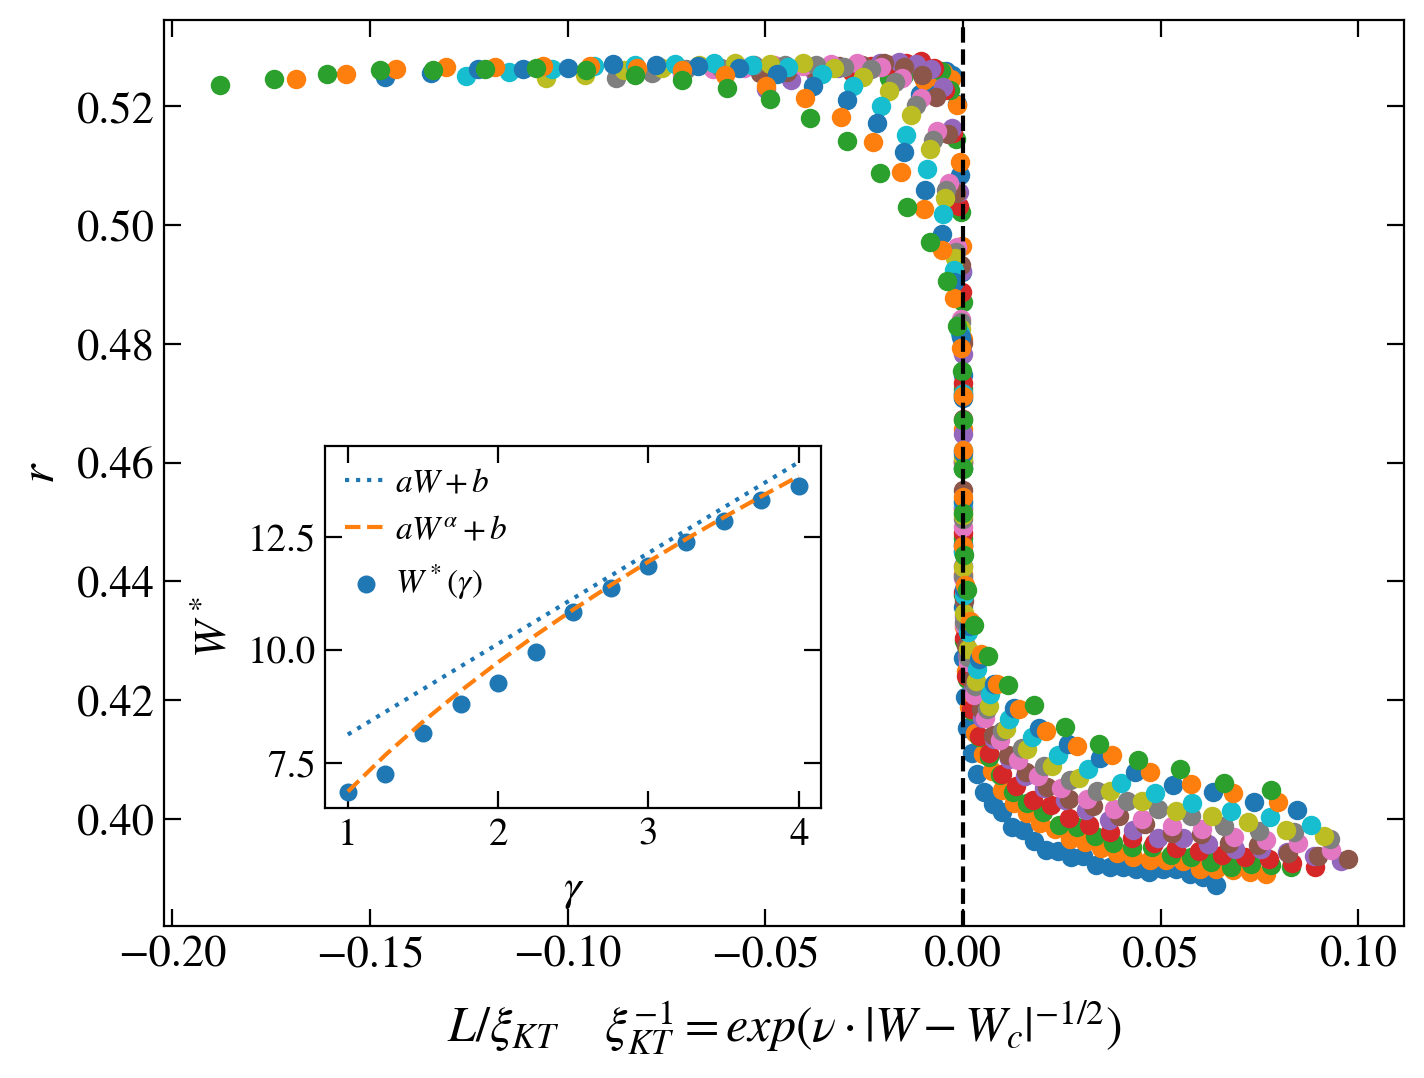

In [49]:
reload_modules()

gamma = 2.25

size=14
W_crit_L14 = []
sizes = np.array(np.arange(10, 15, 1))
def plot_collapsed(scaling_ansatz = 'KT', name="GapRatio", size_collapse = True):
    
    global W_crit_L14
    fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(8,6), dpi = 200)   
    width = 0.4
    height = 0.4
    left, bottom, width, height = [0.13, 0.13, width, height]
    
    inset = fig_help.add_subplot_axes(axis, fig, [left, bottom, width, height]) 

    cost_fun, crit_exp, crit_pars, num_of_crit = load_critical_data(crit_fun='free', scaling_ansatz=scaling_ansatz, name=name, gamma=gamma, L=size, size_collapse=size_collapse)
    xlab = "\ "
    sc_lab = "L" if size_collapse else "\gamma"
    scaling_pars = sizes if size_collapse else gamma_vals
    scaling_pars_plot = sizes - M if size_collapse else gamma_vals

    if num_of_crit > 0:
        cost_fun = np.mean(cost_fun)
        crit_exp = np.median(crit_exp)
        crit_pars = np.array([np.median(crit_pars[i]) for i in range(num_of_crit)])
        
        W_crit_L14 = crit_pars
        rescale_fun = cost.resc_functions_dict[scaling_ansatz]
        critical_fun = cost.crit_functions_dict['free']
        xlab = cost.scale_ansatz_label[scaling_ansatz]('W')
        
        data = [critical_fun(scaling_pars, ii, *crit_pars) for ii in range(len(scaling_pars))]
        inset.scatter(scaling_pars_plot, data, s=30, marker='o', label=r"$W^*(%s)$"%sc_lab)
        
        for ii, xx in enumerate(scaling_pars):
            w, gaps, tau, tH = get_points(xx, gamma) if size_collapse else get_points(size, xx)
            cond = np.log10(1.0 / tau)
            lab = r"$L=%d$"%(xx-M) if size_collapse else r"$\gamma=%.2f$"%(xx)
            if name == "GapRatio":  axis.scatter(rescale_fun(w, scaling_pars, ii, critical_fun, crit_exp, *crit_pars), gaps, marker='o', label=lab)
            else:                   axis.scatter(rescale_fun(w, scaling_pars, ii, critical_fun, crit_exp, *crit_pars), cond, marker='o', label=lab)
            

    fig_help.set_plot_elements(axis, ylabel="$r$", xlabel="$%s$"%xlab, font_size=16, set_legend=False)
    axis.axvline(x=0.0, ls='--', color='black')

    # ADD OTHER CRITICAL ANSATZ
    cost_fun, crit_exp, crit_pars, num_of_crit = load_critical_data(crit_fun='lin', scaling_ansatz=scaling_ansatz, name=name, gamma=gamma, L=size, size_collapse=size_collapse)
    if num_of_crit > 0:
        cost_fun = np.mean(cost_fun)
        crit_exp = np.median(crit_exp)
        crit_pars = np.array([np.median(crit_pars[i]) for i in range(num_of_crit)])
        critical_fun = cost.crit_functions_dict['lin']
        
        data = [critical_fun(scaling_pars, ii, *crit_pars) for ii in range(len(scaling_pars))]
        inset.plot(scaling_pars_plot, data, ls=':', label=r"$aW+b$")

    cost_fun, crit_exp, crit_pars, num_of_crit = load_critical_data(crit_fun='power_law', scaling_ansatz=scaling_ansatz, name=name, gamma=gamma, L=size, size_collapse=size_collapse)
    if num_of_crit > 0:
        cost_fun = np.mean(cost_fun)
        crit_exp = np.median(crit_exp)
        crit_pars = np.array([np.median(crit_pars[i]) for i in range(num_of_crit)])
        critical_fun = cost.crit_functions_dict['power_law']
        
        data = [critical_fun(scaling_pars, ii, *crit_pars) for ii in range(len(scaling_pars))]
        print(crit_pars)
        inset.plot(scaling_pars_plot, data, ls='--', label=r"$aW^\alpha+b$")
        
    fig_help.set_plot_elements(inset, ylabel="$W^*$", xlabel=r"$%s$"%sc_lab, font_size=14, set_legend=True)
    inset.legend(loc = 'upper left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,1.02))

plot_collapsed(name="GapRatio", size_collapse=False)

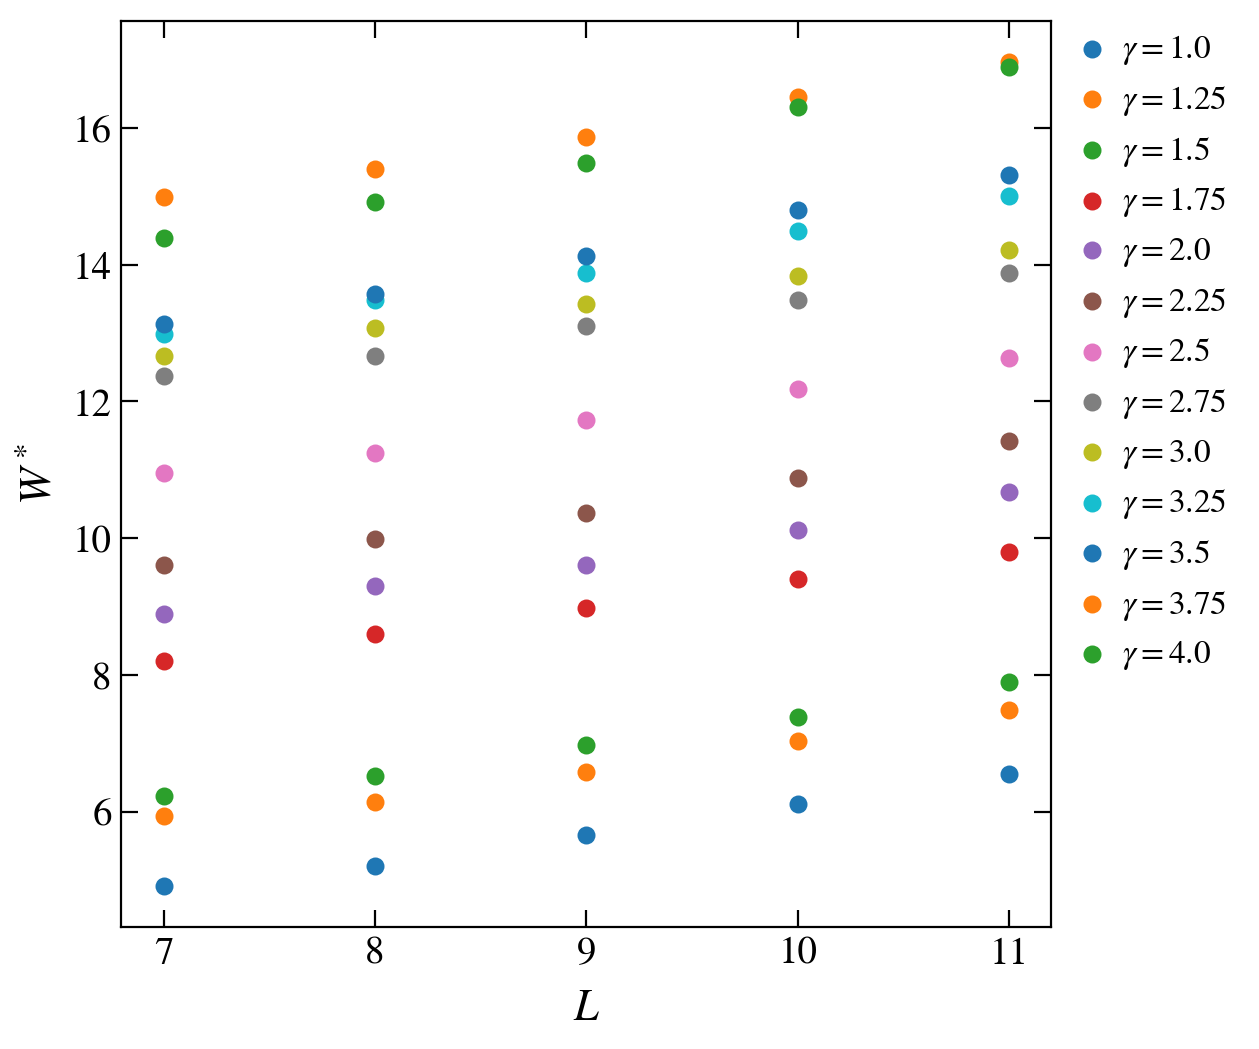

In [21]:
reload_modules()

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,6), dpi = 200)   

leading_coeff = []
gamma_plot = []
W_crit_L14 = []
for gamma in gamma_vals:
    
    cost_fun, crit_exp, crit_pars, num_of_crit = load_critical_data(crit_fun='free', scaling_ansatz='KT', name="GapRatio", gamma=gamma)
    if num_of_crit > 0:
        cost_fun = np.mean(cost_fun)
        crit_exp = np.median(crit_exp)
        crit_pars = np.array([np.median(crit_pars[i]) for i in range(num_of_crit)])
        axis.scatter(sizes - M, crit_pars, s=30, marker='o', label=f"$\gamma={gamma}$")
        W_crit_L14.append(crit_pars[-1])
        gamma_plot.append(gamma)

#axis.scatter(gamma_plot, W_crit_L14)

fig_help.set_plot_elements(axis, ylabel="$W^*$", xlabel="$L$", font_size=14, set_legend=False)
axis.legend(loc = 'upper right', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.22,1.02))
        

# FULL MAPS

In [36]:

FOLDED = False

taus_full = []
gaps1 = []
gaps2 = []
heisenberg_time = []
times = [1]
w_vals = np.linspace(3.0, 20., 35)
gamma_vals = np.linspace(1.0, 4.0, 13)
print(w_vals, gamma_vals)

n_siz = len(gamma_vals)
m_siz = len(w_vals)
epsilon=8e-2
for L in sizes:
    tau_L = np.zeros((n_siz, m_siz))
    tH_L = np.zeros((n_siz, m_siz))
    gaps1_L = np.zeros((n_siz, m_siz))
    gaps2_L = np.zeros((n_siz, m_siz))
    #for alfa in alfa_vals:
    for ii, gamma in enumerate(gamma_vals):
        for jj, w in enumerate(w_vals):
        
            filename = base_dir + "SpectralFormFactor/" + ("folded" if FOLDED else "") + info(L, M, J, gamma, zeta, alfa, h, w, ini_ave)
            if exists(filename):
                data = pd.read_table(filename, sep="\t", header=None)
                times = np.array(data[0])
                sff = np.array(data[1])
                sff = remove_fluctuations(sff, int(0.01 * len(sff)))
                tH = data[2][0]
                times_for_algorithm = times / tH if FOLDED else times
                sff_dev = np.abs(np.log10(sff / GOE(times_for_algorithm)))
                tau = np.nan
                for i, K in reversed(list(enumerate(sff_dev))):
                    if K > epsilon and times[i] < (3 * tH if FOLDED else 3):
                        tau = times[i-1]
                        break

                tau_L[ii, jj] = (tau)
                tH_L[ii, jj] = (tH)

                gap_ratio = data[4][0]
                gaps1_L[ii, jj] = (gap_ratio)

                gap_ratio = data[5][0]
                gaps2_L[ii, jj] = (gap_ratio)
                
                #axis.plot(times, sff, lw=1.5, label=r"$L=%d$"%L)
            else:
                tau_L[ii, jj] = (np.nan)
                tH_L[ii, jj] = (np.nan)
                gaps1_L[ii, jj] = (np.nan)
                gaps2_L[ii, jj] = (np.nan)
                print(filename)

    taus_full.append(np.array(tau_L))
    heisenberg_time.append(np.array(tH_L))
    gaps1.append(np.array(gaps1_L))
    gaps2.append(np.array(gaps2_L))

    #g_cond = np.log10(1.0 / tau_L)
    #
    #t_Th = tau_L / tH_L / np.exp(L/2)
    #axis[0].plot(w_vals / L, g_cond, ls='--', marker='o')
    #axis[1].plot(w_vals / L, gaps_L, ls='--', marker='o', label=r"$L=%d$"%L)
    


[ 3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5
 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.  16.5
 17.  17.5 18.  18.5 19.  19.5 20. ] [1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5  3.75 4.  ]


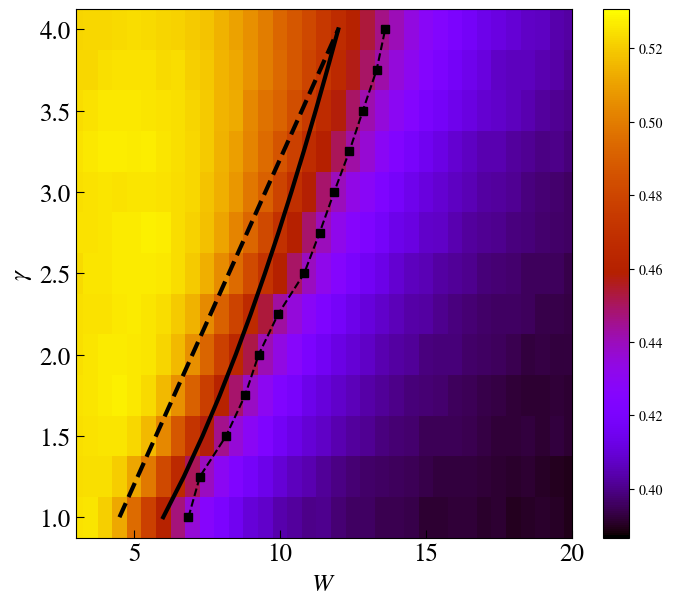

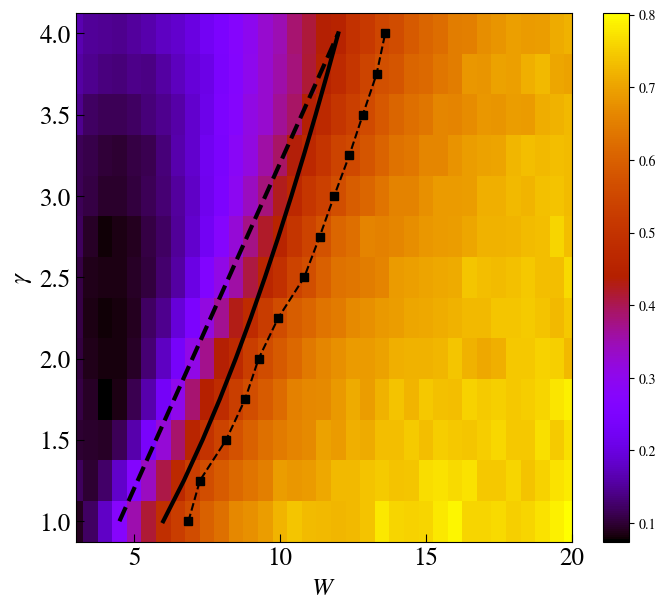

In [42]:

fig, ax1 = plt.subplots( nrows=1, ncols=1, figsize=(8,7), dpi = 100)
fig_th, ax2 = plt.subplots( nrows=1, ncols=1, figsize=(8,7), dpi = 100)
axis = [ax1, ax2]
X, Y = np.meshgrid(w_vals, gamma_vals)
#axis.plot(times, GOE(times), ls='--', color='black')

L = 14
gamma_vals = np.linspace(1.0, 4.0, 13)
idx = list(sizes).index(L)
idx=-2
p1 = axis[0].pcolormesh(X, Y, (gaps2[idx]), shading='nearest', vmin = 0.3867, vmax=0.5307, cmap = 'gnuplot')
p2 = axis[1].pcolormesh(X, Y, (taus_full[idx]), shading='nearest', cmap = 'gnuplot')
for ax in axis:
    ax.set_ylabel(r"$\gamma$", fontsize=18)
    ax.set_xlabel(r"$W$", fontsize=18)
    
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    ax.tick_params(axis='both', which='major', direction="in",length=6, labelsize=18)#, length=font_size-4, width=0.05*font_size)
    ax.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=18)#, length=0.2*(font_size-4), width=0.05*font_size)
    ax.plot(2.5 * gamma_vals+2, gamma_vals, color='black', lw=3, ls='--')
    ax.plot(6*np.sqrt(gamma_vals), gamma_vals, color='black', lw=3)
    ax.set_xlim(3,20)

    ax.plot(W_crit_L14, gamma_vals, marker='s', ls='--', color='black')
fig.colorbar(p1)
fig_th.colorbar(p2)
 
#axis.set_ylim(0, 1.1)

# MOBILITY EDGE

In [ ]:
alfa_vals = np.linspace(0.7, 0.85, 16)

num_of_points = 50
gap_ratio = []
ener = []
L = 15


sizes2 = np.arange(12, 16, 1)
for L in sizes2:
    gap_ratio_L = []
    ener_L = []

    for alfa in alfa_vals:
        r_mean = np.zeros((50))
        ener_L = np.zeros((50))

        counter = 0
        for realis in range(1000 if L < 13 else (2500 if L < 14 else 5000)):
            filename = dir_E + info_raw(L, M, J, zeta, alfa, h, w, ini_ave) + "_real=%d"%realis + ".hdf5"

            if exists(filename):
                counter += 1
                with h5py.File(filename, "r") as file:
                    E = np.array(file.get('eigenvalues/dataset')[0])
                    dim = E.size

                    gaps = np.diff(E)
                    ratio = np.minimum(gaps[:-1], gaps[1:]) / np.maximum(gaps[:-1], gaps[1:])

                    E_rescaled = (E - np.min(E)) / (np.max(E) - np.min(E))
                    for k in range(0, num_of_points):
                        r_mean[k] += np.mean(ratio[ k * (dim // num_of_points) : (k+1) * (dim // num_of_points) ])
                        ener_L[k] += np.mean(E_rescaled[ k * (dim // num_of_points) : (k+1) * (dim // num_of_points) ])
        
        gap_ratio_L.append(r_mean / counter)
        ener_L /= counter
        
        print(L, alfa, counter)
        
    with open(f'rescaled_energy_L={L}.npy', 'wb') as file: np.save(file, ener_L, allow_pickle=True)
    with open(f'gap_ratio_L={L}.npy', 'wb') as file: np.save(file, np.array(gap_ratio_L), allow_pickle=True)

    gap_ratio.append( np.array(gap_ratio_L) )
    ener.append( np.array(ener_L) )



In [ ]:

gap_ratio = []
ener = []
sizes = np.arange(10, 16, 1)
for L in sizes:
    with open(f'results/rescaled_energy_L={L}.npy', 'rb') as file: ener_L = np.load(file, allow_pickle=True)
    with open(f'results/gap_ratio_L={L}.npy', 'rb') as file:       gap_ratio_L = np.load(file, allow_pickle=True)
    gap_ratio.append( np.array(gap_ratio_L) )
    ener.append( np.array(ener_L) )


RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

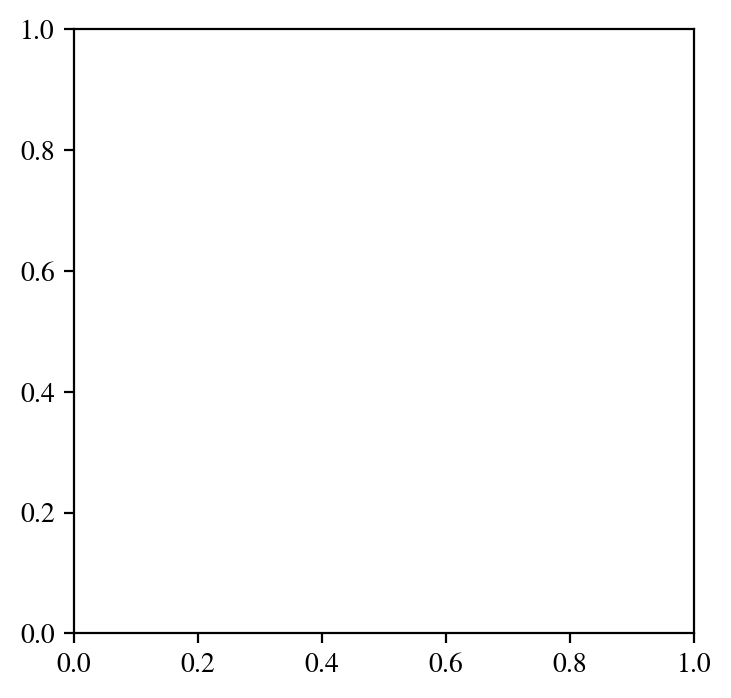

In [ ]:
fig, axis = plt.subplots(ncols=1, nrows=1, dpi=200, figsize=(4, 4))
sizes = np.arange(10, 16, 1)
idx0 = 15
eps = []
alfa_crit = []
for idx in range(35):
    xdata = []
    ydata = []
    for jj, L in enumerate(sizes):
        ratio = []
        for ii, alfa in enumerate(alfa_vals):
            ratio.append(gap_ratio[jj][ii][idx])

        if idx == idx0:
            axis.plot(alfa_vals, ratio, label=r"$L=%d$", ls='--', marker='o')

        xdata.append(np.array(alfa_vals))
        ydata.append(np.array(ratio))
    
    critical = 0
    for r in range(1):
        seed = np.random.default_rng()
        par, crit_pars, costfun, status = cost.get_crit_points(x=np.array(xdata), y=np.array(ydata), vals=sizes, crit_fun='const', scaling_ansatz='RG', seed=seed)
        print(crit_pars[-1])
        
        critical += np.log(crit_pars[-1])
    
    critical = np.exp(critical / 1.0)
    
    print(par, crit_pars, costfun, status, seed, ener[-1][idx], critical)
    eps.append(ener[-1][idx])    
    alfa_crit.append(crit_pars[-1]) 

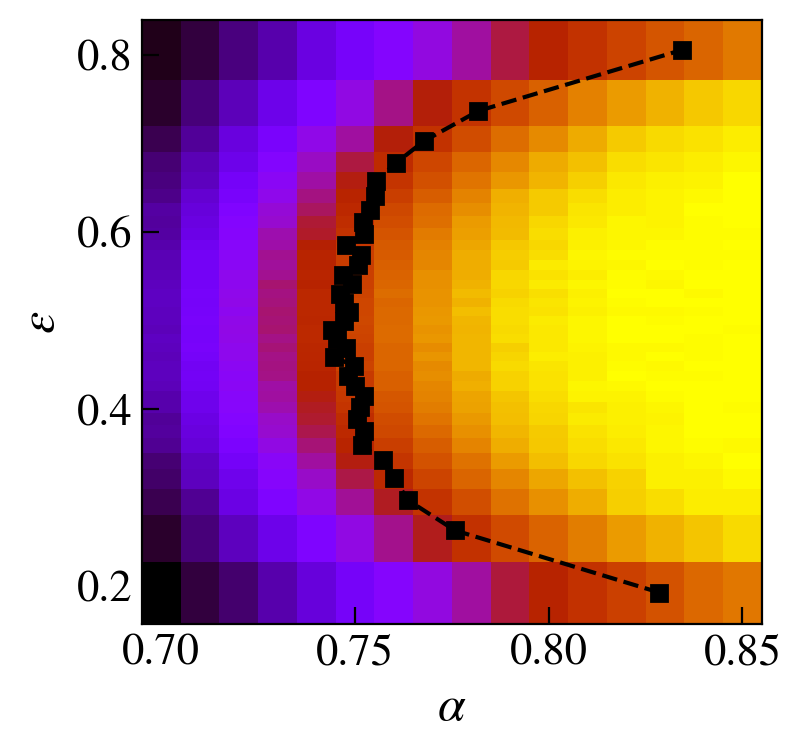

In [ ]:
fig, axis = plt.subplots(ncols=1, nrows=1, dpi=200, figsize=(4, 4))

E_range = np.linspace(0.0, 1.0, 50)

X, Y = np.meshgrid(alfa_vals, ener[-1])

p = axis.pcolormesh(X, Y, np.transpose(gap_ratio[-1]), shading='nearest', vmax=0.5307, cmap = 'gnuplot')

axis.set_ylabel(r'$\epsilon$', fontsize=18)
axis.set_xlabel(r'$\alpha$', fontsize=18)
axis.tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
axis.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
#axis.pcolormesh

axis.plot(alfa_crit, eps, marker='s', ls='--', color='black')

plt.savefig("MobilityEdge.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig("MobilityEdge.png", bbox_inches = 'tight', pad_inches=0.02)

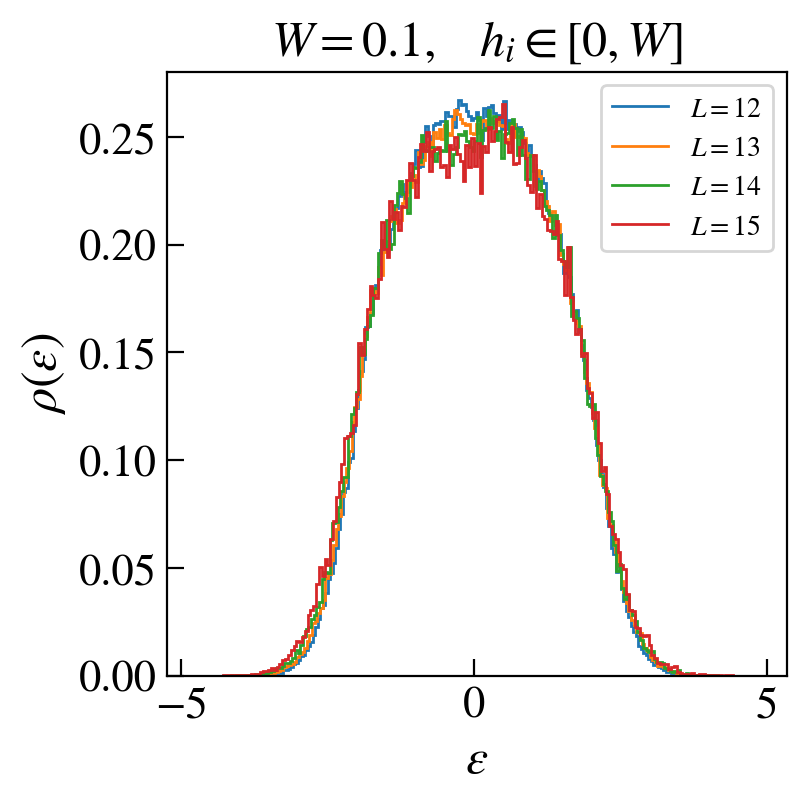

: 

In [ ]:
L=15
alfa=1.0
gamma=1.
h=0.0
w=0.1

fig, axis = plt.subplots(ncols=1, nrows=1, dpi=200, figsize=(4, 4))
for L in [12, 13, 14, 15]:
#for w in [0.5, 1.0, 2.0, 3.0]:
    energies = []
    for realis in range(1000):
        filename = dir_E + info_raw(L, M, J, gamma, zeta, alfa, h, w, ini_ave) + "_real=%d"%realis + ".hdf5"

        if exists(filename):
            with h5py.File(filename, "r") as file:
                E = np.array(file.get('eigenvalues/dataset')[0])
                dim = E.size
                energies = [*energies, *E]
    hist, bins = np.histogram(energies, bins = 200, normed=True)
    axis.stairs(hist, bins, label=r"$L=%d$"%L)
    #axis.stairs(hist, np.array(bins) / w, label=r"$W=%.1f$"%w)


axis.set_ylabel(r'$\rho(\epsilon)$', fontsize=18)
axis.set_xlabel(r'$\epsilon$', fontsize=18)
axis.tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
axis.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
axis.legend()
#axis.set_xlim(-5, 5)

axis.set_title(f"$W={w},\quad h_i\in[0,W]$", fontsize=18)
plt.savefig(f"DOS_L={L}.pdf", bbox_inches = 'tight', pad_inches=0.02)
plt.savefig(f"DOS_L={L}.png", bbox_inches = 'tight', pad_inches=0.02)
